###Objective
This document demonstrates how Variational Autoencoders (VAEs) can be used for generating handwritten digits. Dataset used for training is MNIST data.

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)
Creating the VAE model.....
Training the model.....
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - kl_loss: 25.2849 - loss: 367.4182 - reconstruction_loss: 342.1333
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - kl_loss: 12.2943 - loss: 205.0581 - reconstruction_loss: 192.7637
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 7.7759 - loss: 193.4371 - reconstruction_loss: 185.6611
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - kl_loss: 6.3236 - loss: 188.7196 - reconstruction_loss: 182.3960
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - kl_loss: 5.6164 - loss: 185.8064 - reconstruction_loss: 180.1900
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 5.2376 - loss: 182.8920 - reconstruction_loss: 177.6543
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - kl_loss: 5.0344 - loss: 180.1728 - reconstruction_loss: 175.1384
Epoch 8/30
46

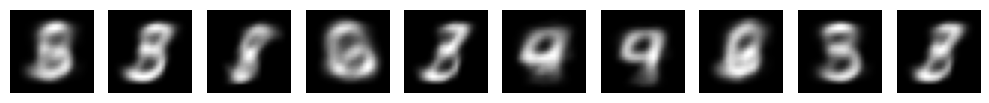

In [3]:
# load MNIST dataset
# y_train is only used to visualize latent space later on
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# change datatype of x_train and normalize it
x_train = x_train.astype('float32') / 255.0

# change shape of x_train to 28, 28, 1.
# len(x_train) returns 60000 (the number of training images)
# 28, 28 represents the height and width of each image, as MNIST digits are 28x28 pixels.
# 1 represents a single channel for grayscale images
print(x_train.shape)
x_train = x_train.reshape(len(x_train), 28, 28, 1)
print(x_train.shape)

# define hyperparameters
input_shape = (28, 28, 1)
# batch_size denotes how many samples will be processed together in 1 training cycle
batch_size = 128
# latent_dim is the dimensioanlity of latent space, i.e., This is the number of
# dimensions in the compressed, hidden representation of the input data that the encoder learns
latent_dim = 2
# intermediate_dim is the number of neurons in Dense layer
intermediate_dim = 512
# epochs denotes how many times will training process will consume consume entire dataset
epochs = 30

# custome keras layer designed to sample from a distribution defined by z_mean and z_log_var
class Sampling(Layer):
  def call(self, inputs):
    # z_mean is best guess where our data points will be in latent space
    # z_log_var denotes the spread or uncertainty of the latent representation
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    # reparametrization trick - random noise tensor epsilon samples from normal distribution
    # shape = (batch, dim) since we need to add it to z_mean later
    epsilon = tf.random.normal(shape=(batch, dim))
    # z is the actual latent vector used for reconstruction by the decoder.
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    return z

# encoder
encoder_input = Input(shape=input_shape)
x = Flatten()(encoder_input)
# intermediate_dim specifies the number of neurons (or units) in the layer
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# after creating the Sampling instance, it's immediately called with a list containing z_mean and z_log_var as its input
z = Sampling()([z_mean, z_log_var])
# combine/pass these input and output into keras model
# [z_mean, z_log_var, z]: This is a list of the output tensors from the encoder
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

# decoder
# by adding the comma, (latent_dim,), we explicitly tell Python to create a tuple
# containing latent_dim as its only element. So, if latent_dim is 2,
# then (latent_dim,) results in the tuple (2,)
decoder_input = Input(shape=(latent_dim, ))
x = Dense(intermediate_dim, activation='relu')(decoder_input)
# sigmoid activation function in below layer because we want output of this layer to have values between 0 and 1
# this is crucial for generating images like MNIST digits, where each pixel
# intensity is typically represented as a floating-point number between 0 (black) and 1 (white)
x = Dense(784, activation='sigmoid')(x)
# take 784 values from previous layer and reshape them into (28, 28) pixel format
decoder_output = Reshape((28, 28, 1))(x)
decoder = Model(decoder_input, decoder_output, name='decoder')

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        # call the constructor of the parent class (tf.keras.Model)
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # average total loss during training
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        # average reconstruction loss
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        # average KL divergence loss
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        # tf.GradientTape() is a context manager records all operations performed within its scope
        # to compute gradients later. This is how Keras determines how to update the model's weights
        with tf.GradientTape() as tape:
            # Encoder output
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruction
            reconstruction = self.decoder(z)

            # Flatten input and reconstruction ro calculate binary crossentropy
            flat_data = tf.reshape(data, (-1, 784))
            flat_reconstruction = tf.reshape(reconstruction, (-1, 784))

            # Reconstruction loss (fixed axis handling)
            # binary_crossentropy is used because the pixel values are between 0 and 1, representing probabilities
            # multiplied by 784 (28*28) to scale it to the number of pixels
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(
                    flat_data,
                    flat_reconstruction
                )
            ) * 784

            # KL divergence loss
            # this is the Kullback-Leibler divergence loss. It measures how much
            # the learned latent distribution (N(z_mean, exp(z_log_var))) deviates from a standard normal distribution (N(0, 1)).
            # This term encourages the latent space to be well-behaved and makes sampling new data easier
            # analytical solution for KL divergence between two Gaussian distributions
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            # total loss
            total_loss = reconstruction_loss + kl_loss

        # compute gradients of the total_loss with respect to all trainable weights in the VAE model (encoder and decoder weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        # apply the calculated gradients to update the model's weights using the optimizer (e.g., Adam) that was compiled with the model
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # update the state of the loss metrics with the current step's loss values
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # result() returns the average of all values accumulated since the last reset_state() call.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

# create the VAE model
print("Creating the VAE model.....")
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# train the model
print("Training the model.....")
vae.fit(x_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# generate n new digits using decoder
# n=10 fpr 10 digits
def generate_digits(decoder, n=10):
  # generates random numbers from a standard normal (Gaussian) distribution
  # creates n samples, where each sample is a vector of latent_dim dimensions
  z_sample = np.random.normal(size=(n, latent_dim))
  # take these latent vectors and output their corresponding reconstructed images
  x_decoded = decoder.predict(z_sample)
  return x_decoded

print("Generating new digits after training.....")
newly_generated_digits = generate_digits(decoder, 10)

print("Visualize the generated digits")
plt.figure(figsize=(10, 5))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(newly_generated_digits[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


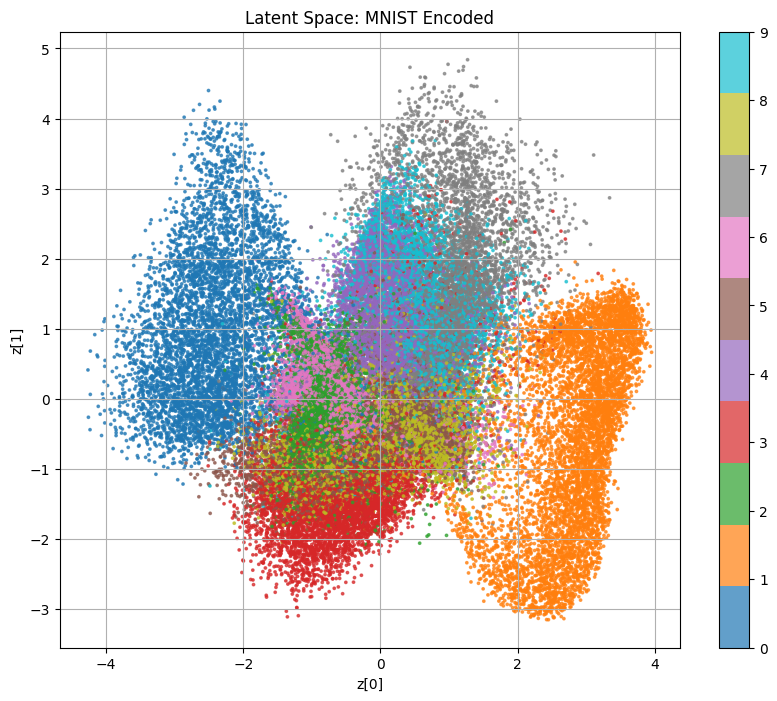

In [4]:
# visulaize latent space
z_mean, z_log_var, z = encoder.predict(x_train, batch_size=128)
plt.figure(figsize=(10, 8))
scatter_plot = plt.scatter(z_mean[:,0], z_mean[:,1], s=3, c=y_train, cmap='tab10', alpha=0.7)
plt.colorbar(scatter_plot, ticks=range(10))
plt.title("Latent Space: MNIST Encoded")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()